In [1]:
%load_ext sparkmagic.magics

In [3]:
import os
from IPython import get_ipython

# set the application name as "<your_gaspar_id>-homework3"
username = os.environ['RENKU_USERNAME']
server = "http://iccluster029.iccluster.epfl.ch:8998"

get_ipython().run_cell_magic(
    'spark',
    line='config', 
    cell="""{{ "name": "{0}-final", "executorMemory": "4G", "executorCores": 4, "numExecutors": 10, "driverMemory": "4G"}}""".format(username)
)

In [4]:
get_ipython().run_line_magic(
    "spark", "add -s {0}-final -l python -u {1} -k".format(username, server)
)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
7092,application_1652960972356_2765,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


In [5]:
%%spark
import pyspark.sql.functions as functions

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Data in 15/05/2019

In [6]:
%%spark
from pyspark.sql.types import IntegerType

df = spark.read.option("header",True).csv('/user/sixu/work/stop_times_515_in_radius_01.csv')
# cast string to int
df = df.withColumn("stop_sequence", df["stop_sequence"].cast(IntegerType()))
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- trip_id: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stop_sequence: integer (nullable = true)
 |-- pickup_type: string (nullable = true)
 |-- drop_off_type: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- stop_id: string (nullable = true)

In [7]:
%%spark
df.sort(['trip_id','stop_sequence'], ascending=True).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------+-------------+-----------+-------------+----+-----+---+------------+
|             trip_id|arrival_time|departure_time|stop_sequence|pickup_type|drop_off_type|year|month|day|     stop_id|
+--------------------+------------+--------------+-------------+-----------+-------------+----+-----+---+------------+
|1.TA.1-1-E-j19-1.1.H|    05:39:00|      05:39:00|           23|          0|            0|2019|    5| 15|     8590314|
|1.TA.1-1-E-j19-1.1.H|    05:40:00|      05:40:00|           24|          0|            0|2019|    5| 15|     8578679|
|  1.TA.1-1-j19-1.1.H|    05:19:00|      05:19:00|            1|          0|            0|2019|    5| 15|8503000:0:13|
| 1.TA.1-10-j19-1.1.R|    06:03:00|      06:03:00|            1|          0|            0|2019|    5| 15|     8590274|
| 1.TA.1-10-j19-1.1.R|    06:04:00|      06:04:00|            2|          0|            0|2019|    5| 15|     8590272|
| 1.TA.1-10-j19-1.1.R|    06:05:00|      06:05:0

# Join with stops

In [8]:
%%spark
stops = spark.read.option("header",True).csv('/user/sixu/work/stops_in_radius.csv')
stops = stops.withColumnRenamed("stop_id","stop_id2")

df_stops = df.join(stops, df.stop_id==stops.stop_id2, "inner")
df_stops = df_stops.drop("stop_id2")
df_stops.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2296723

In [10]:
%%spark
df_stops.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------+-------------+-----------+-------------+----+-----+---+-----------+---+---------+---------+--------+
|             trip_id|arrival_time|departure_time|stop_sequence|pickup_type|drop_off_type|year|month|day|    stop_id|_c0|stop_name| stop_lat|stop_lon|
+--------------------+------------+--------------+-------------+-----------+-------------+----+-----+---+-----------+---+---------+---------+--------+
|7.TA.10-25-j19-1.6.R|    06:17:00|      06:17:00|           20|          0|            0|2019|    5| 15|8503000:0:5|128|Zürich HB|47.378178|8.540212|
|9.TA.10-25-j19-1.6.R|    07:17:00|      07:17:00|           20|          0|            0|2019|    5| 15|8503000:0:5|128|Zürich HB|47.378178|8.540212|
|10.TA.10-25-j19-1...|    07:17:00|      07:17:00|           20|          0|            0|2019|    5| 15|8503000:0:5|128|Zürich HB|47.378178|8.540212|
|14.TA.10-25-j19-1...|    08:17:00|      08:17:00|           20|          0|            0|2019

In [42]:
# %%spark
# df_stops.write.option("header",True).csv("/user/sixu/work/data_515.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Test plot

In [12]:
%%spark
l = ['1.TA.1-205-j19-1.1.H', '1.TA.1-231-j19-1.1.H', '1.TA.1-245-j19-1.1.R', '1.TA.1-303-j19-1.1.R', '1.TA.1-303-j19-1.1.R']
trips5 = df_stops.filter(df_stops.trip_id.isin(l))
trips5.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

52

In [13]:
%%spark
trips5=trips5.withColumn('stop_lat',trips5['stop_lat'].cast("float"))
trips5=trips5.withColumn('stop_lon',trips5['stop_lon'].cast("float"))
trips5.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- trip_id: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stop_sequence: integer (nullable = true)
 |-- pickup_type: string (nullable = true)
 |-- drop_off_type: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- stop_id: string (nullable = true)
 |-- _c0: string (nullable = true)
 |-- stop_name: string (nullable = true)
 |-- stop_lat: float (nullable = true)
 |-- stop_lon: float (nullable = true)

In [35]:
%%spark -o df_plot
df_plot = trips5

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
df_plot[:5]

,trip_id,arrival_time,departure_time,stop_sequence,pickup_type,drop_off_type,year,month,day,stop_id,_c0,stop_name,stop_lat,stop_lon
0,1.TA.1-205-j19-1.1.H,24:42:00,24:42:00,1,0,0,2019-01-01,5,15,8573726:0:D,735,"Bonstetten-Wettswil, Bahnhof",47.326298,8.468499
1,1.TA.1-205-j19-1.1.H,24:44:00,24:44:00,2,0,0,2019-01-01,5,15,8583805,1014,"Bonstetten, Dorfstrasse",47.317123,8.463729
2,1.TA.1-205-j19-1.1.H,24:45:00,24:45:00,3,0,0,2019-01-01,5,15,8581666,985,"Bonstetten, Lätten",47.318900,8.455788
3,1.TA.1-205-j19-1.1.H,24:48:00,24:48:00,4,0,0,2019-01-01,5,15,8573725,729,"Islisberg, Dorf",47.323630,8.439349
4,1.TA.1-205-j19-1.1.H,24:49:00,24:49:00,5,0,0,2019-01-01,5,15,8583206,1003,"Islisberg, Räbacher",47.321636,8.435325


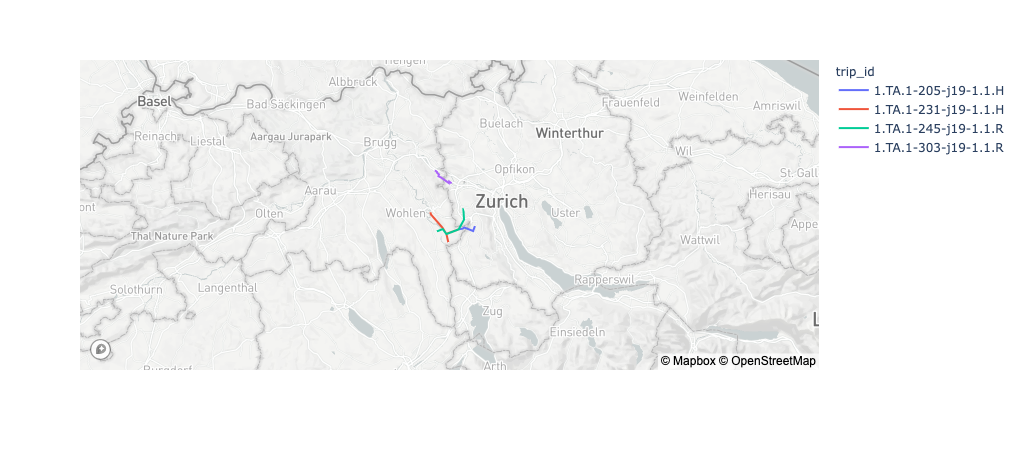

In [40]:
import plotly.express as px
token = "pk.eyJ1IjoiY29jb251dG51dCIsImEiOiJjbDNscTZhbHowMmxtM2pwajl3Yjd1ejF0In0.PXbwkPmWYXrAhQsus3ypVA"
px.set_mapbox_access_token(token)
fig = px.line_mapbox(df_plot, lat="stop_lat", lon="stop_lon", color="trip_id")
fig.show()